# TFT Hyperparameter Tuning - Previsione Fotovoltaica 24h

## Obiettivo
Ottimizzazione degli iperparametri del Temporal Fusion Transformer (TFT) per la previsione della produzione fotovoltaica a 24 ore utilizzando:

- **Dataset completo (100%)** con temporal cross-validation 80/20
- **Ottimizzazione Bayesiana** tramite Optuna
- **Salvataggio automatico** dei migliori iperparametri

---

## Pipeline Hyperparameter Tuning

1. **Data Loading & Full Dataset Preparation**
2. **Temporal Cross-Validation Setup** (80% train / 20% validation)
3. **Hyperparameter Search Configuration** (Optuna)
4. **Training & Validation Loop** con Early Stopping
5. **Results Analysis & Best Model Selection**
6. **Export Best Hyperparameters** to .txt file

## 1. Import Required Libraries

Import di tutte le librerie necessarie per hyperparameter tuning

In [2]:
# Data manipulation & base libraries
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import warnings
import json
import time
import gc
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# PyTorch & PyTorch Lightning
import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

# PyTorch Forecasting
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss
from pytorch_forecasting.data import GroupNormalizer

# Metrics & Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Hyperparameter Optimization
import optuna
try:
    from optuna.integration import PyTorchLightningPruningCallback
except ImportError:
    print("⚠️  optuna-integration non trovato. Installazione in corso...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "optuna-integration[pytorch_lightning]"])
    from optuna.integration import PyTorchLightningPruningCallback

print("="*70)
print("CONFIGURAZIONE SISTEMA")
print("="*70)
print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"Optuna version: {optuna.__version__}")

print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"CUDA Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
print("="*70)

⚠️  optuna-integration non trovato. Installazione in corso...
CONFIGURAZIONE SISTEMA
PyTorch version: 2.7.1+cu118
PyTorch Lightning version: 2.5.6
Optuna version: 4.6.0
Device: NVIDIA GeForce RTX 4060
CUDA Memory: 8.00 GB


In [3]:
# Installazione dipendenze mancanti (eseguire solo se necessario)
import subprocess
import sys

def install_package(package):
    """Installa un pacchetto usando pip"""
    try:
        import importlib
        importlib.import_module(package.split('>=')[0].split('==')[0])
        print(f"✓ {package} già installato")
        return True
    except ImportError:
        print(f"📦 Installazione {package}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"✅ {package} installato con successo")
            return True
        except subprocess.CalledProcessError:
            print(f"❌ Errore nell'installazione di {package}")
            return False

# Lista dei pacchetti necessari per hyperparameter tuning
required_packages = [
    "optuna>=3.4.0",
    "optuna-integration[pytorch_lightning]"
]

print("="*60)
print("CONTROLLO E INSTALLAZIONE DIPENDENZE")
print("="*60)

all_installed = True
for package in required_packages:
    if not install_package(package):
        all_installed = False

if all_installed:
    print("\n✅ Tutte le dipendenze sono installate correttamente!")
else:
    print("\n⚠️ Alcune dipendenze potrebbero non essere state installate.")
    print("Se necessario, esegui manualmente: pip install optuna")

print("="*60)

CONTROLLO E INSTALLAZIONE DIPENDENZE
✓ optuna>=3.4.0 già installato
📦 Installazione optuna-integration[pytorch_lightning]...
✅ optuna-integration[pytorch_lightning] installato con successo

✅ Tutte le dipendenze sono installate correttamente!


## 2. Data Loading & Full Dataset Preparation

Caricamento del dataset completo (100%) e preparazione per hyperparameter tuning

In [4]:
def load_full_dataset():
    """
    Carica e prepara il dataset completo PV + meteo
    Returns:
        pd.DataFrame: Dataset completo processato
    """
    print("="*70)
    print("CARICAMENTO DATASET COMPLETO")
    print("="*70)
    
    # Trova la directory root del progetto
    project_root = Path('..').resolve()
    
    # Funzione per trovare file CSV
    def find_csv_file(filename):
        possible_paths = [
            project_root / 'data' / 'raw' / filename,
            project_root / 'data' / filename,
            project_root / filename,
            Path('.') / filename,
            Path('..') / filename
        ]
        
        for path in possible_paths:
            if path.exists():
                print(f"✓ Trovato: {filename}")
                return str(path)
        
        print(f"✗ Non trovato: {filename}")
        return None
    
    # Trova e carica i file CSV
    pv_file1 = find_csv_file("pv_dataset - 07-10--06-11.csv")
    pv_file2 = find_csv_file("pv_dataset - 07-11--06-12.csv")
    wx_file1 = find_csv_file("wx_dataset - 07-10--06-11.csv")
    wx_file2 = find_csv_file("wx_dataset - 07-11--06-12.csv")
    
    if not all([pv_file1, pv_file2, wx_file1, wx_file2]):
        raise FileNotFoundError("Non tutti i file CSV sono stati trovati!")
    
    print("\nCaricamento dati PV...")
    pv1 = pd.read_csv(pv_file1)
    pv2 = pd.read_csv(pv_file2)
    pv_data = pd.concat([pv1, pv2], ignore_index=True)
    
    # Rinomina colonne PV
    timestamp_col = "Max kWp"
    target_col = [col for col in pv_data.columns if col != timestamp_col][0]
    pv_data = pv_data.rename(columns={timestamp_col: 'datetime', target_col: 'power_kw'})
    
    print("\nCaricamento dati meteo...")
    wx1 = pd.read_csv(wx_file1)
    wx2 = pd.read_csv(wx_file2)
    wx_data = pd.concat([wx1, wx2], ignore_index=True)
    wx_data = wx_data.rename(columns={'dt_iso': 'datetime'})
    
    print("\nProcessing timestamps...")
    # Conversione timestamp
    pv_data['datetime'] = pd.to_datetime(pv_data['datetime'], format='mixed', utc=True).dt.tz_localize(None)
    wx_data['datetime'] = pd.to_datetime(wx_data['datetime'], format='mixed', utc=True).dt.tz_localize(None)
    
    # Rimuovi duplicati
    pv_data = pv_data.drop_duplicates(subset=['datetime'], keep='first')
    wx_data = wx_data.drop_duplicates(subset=['datetime'], keep='first')
    
    # Merge datasets
    data = pd.merge(pv_data, wx_data, on='datetime', how='inner')
    data = data.sort_values('datetime').reset_index(drop=True)
    
    print(f"\nDataset merged shape: {data.shape}")
    print(f"Range temporale: {data['datetime'].min()} to {data['datetime'].max()}")
    
    return data

# Carica dataset
full_data = load_full_dataset()

CARICAMENTO DATASET COMPLETO
✓ Trovato: pv_dataset - 07-10--06-11.csv
✓ Trovato: pv_dataset - 07-11--06-12.csv
✓ Trovato: wx_dataset - 07-10--06-11.csv
✓ Trovato: wx_dataset - 07-11--06-12.csv

Caricamento dati PV...

Caricamento dati meteo...

Processing timestamps...

Dataset merged shape: (17317, 16)
Range temporale: 2010-07-01 00:00:00 to 2012-06-30 13:00:00


In [5]:
def preprocess_data(data):
    """
    Preprocessing completo del dataset: missing values, feature engineering
    """
    print("\n" + "="*70)
    print("PREPROCESSING DATA")
    print("="*70)
    
    # Gestione valori mancanti
    print("Gestione valori mancanti...")
    
    # rain_1h: NaN = 0 (nessuna pioggia)
    if 'rain_1h' in data.columns:
        data['rain_1h'] = data['rain_1h'].fillna(0)
        print("✓ rain_1h: NaN sostituiti con 0")
    
    # Interpolazione per altre colonne numeriche
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric_cols:
        if col != 'power_kw' and data[col].isnull().sum() > 0:
            data[col] = data[col].interpolate(method='linear', limit=5)
            data[col] = data[col].fillna(method='ffill', limit=2)
    
    # Gestione power_kw
    if 'power_kw' in numeric_cols:
        data['power_kw'] = data['power_kw'].interpolate(method='linear', limit=3)
        data['power_kw'] = data['power_kw'].fillna(method='ffill', limit=1)
    
    # Rimuovi righe con NaN rimanenti
    rows_before = len(data)
    data = data.dropna()
    print(f"Righe rimosse: {rows_before - len(data)}")
    
    # Feature Engineering
    print("\nFeature Engineering...")
    
    # Feature temporali
    data['hour'] = data['datetime'].dt.hour
    data['day_of_month'] = data['datetime'].dt.day
    data['month'] = data['datetime'].dt.month
    data['day_of_week'] = data['datetime'].dt.dayofweek
    
    # Group ID e time index per TFT
    data['group_id'] = 'PV1'
    data['time_idx'] = np.arange(len(data)).astype(int)
    
    # Conversione tipi
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric_cols:
        if col != 'time_idx':
            data[col] = data[col].astype(np.float32)
    
    print(f"✓ Dataset processato: {data.shape}")
    print(f"✓ Feature temporali: hour, day_of_month, month, day_of_week")
    print(f"✓ group_id e time_idx creati")
    
    return data

# Preprocessing completo
processed_data = preprocess_data(full_data.copy())

print(f"\nDataset finale: {processed_data.shape}")
print(f"Colonne: {processed_data.columns.tolist()}")


PREPROCESSING DATA
Gestione valori mancanti...
✓ rain_1h: NaN sostituiti con 0
Righe rimosse: 0

Feature Engineering...
✓ Dataset processato: (17317, 22)
✓ Feature temporali: hour, day_of_month, month, day_of_week
✓ group_id e time_idx creati

Dataset finale: (17317, 22)
Colonne: ['datetime', 'power_kw', 'lat', 'lon', 'temp', 'dew_point', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'clouds_all', 'weather_description', 'Dhi', 'Dni', 'Ghi', 'hour', 'day_of_month', 'month', 'day_of_week', 'group_id', 'time_idx']


## 3. Temporal Cross-Validation Setup (80/20)

Configurazione della temporal cross-validation per evitare data leakage

In [6]:
# Configurazione TFT - Parametri fissi
MAX_ENCODER_LENGTH = 168  # 1 settimana di contesto
MAX_PREDICTION_LENGTH = 24  # Previsione 24 ore

def setup_temporal_cross_validation(data, n_folds=5, val_ratio=0.2):
    """
    Temporal Cross-Validation con fold bilanciati per evitare data leakage
    
    Args:
        data: Dataset completo
        n_folds: Numero di fold temporali
        val_ratio: Percentuale fissa per validation set (es. 0.2 = 20%)
    
    Returns:
        list: Lista di tuple (train_data, val_data) per ogni fold
    """
    print("="*70)
    print("TEMPORAL CROSS-VALIDATION SETUP (BALANCED FOLDS)")
    print("="*70)
    
    max_time_idx = data['time_idx'].max()
    total_samples = len(data)
    val_size = int(total_samples * val_ratio)  # Validation set fisso (20%)
    folds = []
    
    print(f"Dataset totale: {total_samples} samples")
    print(f"Validation size fisso: {val_size} samples ({val_ratio*100:.1f}%)")
    print(f"Min training per fold: {total_samples - val_size} samples")
    
    # Calcola la dimensione incrementale per il training set
    min_train_size = int(total_samples * 0.5)  # Minimo 50% per training
    max_train_size = total_samples - val_size  # Massimo possibile
    
    for fold in range(n_folds):
        # Training size cresce progressivamente
        progress = fold / (n_folds - 1)  # 0.0 a 1.0
        train_size = int(min_train_size + progress * (max_train_size - min_train_size))
        
        # Assicura che train + val non superi il dataset
        if train_size + val_size > total_samples:
            train_size = total_samples - val_size
            
        # Calcola cutoff temporali
        train_cutoff = train_size - 1  # time_idx da 0 a train_cutoff
        val_start = train_cutoff + 1
        val_cutoff = val_start + val_size - 1
        
        # Assicura che non superi i limiti del dataset
        if val_cutoff >= max_time_idx:
            val_cutoff = max_time_idx
            val_start = val_cutoff - val_size + 1
            train_cutoff = val_start - 1
            
        # Skip se training set troppo piccolo
        if train_cutoff < MAX_ENCODER_LENGTH + MAX_PREDICTION_LENGTH:
            print(f"Skipping fold {fold + 1}: training set troppo piccolo")
            continue
            
        # Skip se validation set troppo piccolo
        if (val_cutoff - val_start + 1) < MAX_PREDICTION_LENGTH * 5:
            print(f"Skipping fold {fold + 1}: validation set troppo piccolo")
            continue
            
        train_data = data[data['time_idx'] <= train_cutoff].copy()
        val_data = data[(data['time_idx'] >= val_start) & (data['time_idx'] <= val_cutoff)].copy()
        
        folds.append((train_data, val_data))
        
        print(f"\nFold {fold + 1}/{n_folds}:")
        print(f"  Training: {len(train_data)} samples ({len(train_data)/total_samples*100:.1f}%)")
        print(f"  Validation: {len(val_data)} samples ({len(val_data)/total_samples*100:.1f}%)")
        print(f"  Train range: {train_data['datetime'].min()} to {train_data['datetime'].max()}")
        print(f"  Val range: {val_data['datetime'].min()} to {val_data['datetime'].max()}")
        print(f"  Gap check: {val_data['time_idx'].min() - train_data['time_idx'].max() - 1} hours between train/val")
    
    print(f"\n✓ Creati {len(folds)} fold temporali validi con validation set bilanciato")
    return folds

# Setup temporal cross-validation con fold bilanciati
folds = setup_temporal_cross_validation(processed_data, n_folds=5, val_ratio=0.2)

def identify_features(data):
    """
    Identifica le feature per TFT
    """
    # Colonne meteo disponibili
    weather_cols = []
    for col in ['temp', 'Dni', 'Ghi', 'humidity', 'clouds_all', 'wind_speed', 'pressure', 'rain_1h']:
        if col in data.columns:
            weather_cols.append(col)
    
    # Feature temporali
    time_features = ['hour', 'day_of_month', 'month', 'day_of_week']
    
    # Known reals (note nel futuro)
    known_reals = time_features + weather_cols
    return known_reals

known_reals = identify_features(processed_data)

print(f"\n📊 Cross-validation configurata con {len(folds)} fold")
print("Ogni trial verrà validato su tutti i fold per robustezza")
print(f"\nFeature identificate:")
print(f"  - Static categoricals: ['group_id']")
print(f"  - Unknown reals: ['power_kw']")
print(f"  - Known reals total: {len(known_reals)}")
print(f"  - Weather features: {[col for col in known_reals if col not in ['hour', 'day_of_month', 'month', 'day_of_week']]}")
print(f"  - Time features: {['hour', 'day_of_month', 'month', 'day_of_week']}")

TEMPORAL CROSS-VALIDATION SETUP (BALANCED FOLDS)
Dataset totale: 17317 samples
Validation size fisso: 3463 samples (20.0%)
Min training per fold: 13854 samples

Fold 1/5:
  Training: 8658 samples (50.0%)
  Validation: 3463 samples (20.0%)
  Train range: 2010-07-01 00:00:00 to 2011-07-05 18:00:00
  Val range: 2011-07-05 19:00:00 to 2011-11-27 01:00:00
  Gap check: 0 hours between train/val

Fold 2/5:
  Training: 9957 samples (57.5%)
  Validation: 3463 samples (20.0%)
  Train range: 2010-07-01 00:00:00 to 2011-08-28 21:00:00
  Val range: 2011-08-28 22:00:00 to 2012-01-20 04:00:00
  Gap check: 0 hours between train/val

Fold 3/5:
  Training: 11256 samples (65.0%)
  Validation: 3463 samples (20.0%)
  Train range: 2010-07-01 00:00:00 to 2011-10-22 00:00:00
  Val range: 2011-10-22 01:00:00 to 2012-03-14 07:00:00
  Gap check: 0 hours between train/val

Fold 4/5:
  Training: 12555 samples (72.5%)
  Validation: 3463 samples (20.0%)
  Train range: 2010-07-01 00:00:00 to 2011-12-15 03:00:00
  Val

## 4. Hyperparameter Search Configuration (Optuna)

Definizione dello spazio di ricerca per gli iperparametri del TFT

In [7]:
def suggest_hyperparameters(trial):
    """
    Definisce lo spazio di ricerca degli iperparametri per Optuna
    """
    hyperparams = {
        # Architettura del modello
        'hidden_size': trial.suggest_categorical('hidden_size', [64, 128, 192, 256]),
        'lstm_layers': trial.suggest_int('lstm_layers', 1, 3),
        'attention_head_size': trial.suggest_categorical('attention_head_size', [1, 2, 4, 8]),
        'hidden_continuous_size': trial.suggest_categorical('hidden_continuous_size', [8, 16, 32]),
        
        # Regolarizzazione
        'dropout': trial.suggest_float('dropout', 0.1, 0.4),
        
        # Training parameters
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
        
        # Early stopping patience
        'patience': trial.suggest_int('patience', 10, 30),
        
        # Gradient clipping
        'gradient_clip_val': trial.suggest_float('gradient_clip_val', 0.1, 2.0),
    }
    
    return hyperparams

# Configurazione Optuna Study
def create_optuna_study():
    """
    Crea studio Optuna per l'ottimizzazione
    """
    study = optuna.create_study(
        direction="minimize",  # Minimizza validation loss
        study_name="tft_hyperparameter_tuning",
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)
    )
    return study

print("="*70)
print("CONFIGURAZIONE HYPERPARAMETER SEARCH")
print("="*70)
print("Spazio di ricerca definito:")
print("  - hidden_size: [64, 128, 192, 256]")
print("  - lstm_layers: [1, 2, 3]")
print("  - attention_head_size: [1, 2, 4, 8]")
print("  - hidden_continuous_size: [8, 16, 32]")
print("  - dropout: [0.1, 0.4]")
print("  - learning_rate: [1e-4, 1e-1] (log)")
print("  - batch_size: [32, 64, 128]")
print("  - patience: [10, 30]")
print("  - gradient_clip_val: [0.1, 2.0]")
print("\nAlgoritmo: TPE Sampler")
print("Pruning: Median Pruner")
print("="*70)

CONFIGURAZIONE HYPERPARAMETER SEARCH
Spazio di ricerca definito:
  - hidden_size: [64, 128, 192, 256]
  - lstm_layers: [1, 2, 3]
  - attention_head_size: [1, 2, 4, 8]
  - hidden_continuous_size: [8, 16, 32]
  - dropout: [0.1, 0.4]
  - learning_rate: [1e-4, 1e-1] (log)
  - batch_size: [32, 64, 128]
  - patience: [10, 30]
  - gradient_clip_val: [0.1, 2.0]

Algoritmo: TPE Sampler
Pruning: Median Pruner


## 5. Training & Validation Loop

Implementazione del training loop con Optuna per l'ottimizzazione degli iperparametri

In [8]:
def objective(trial):
    """
    Funzione obiettivo per Optuna con temporal cross-validation
    Valuta gli iperparametri su tutti i fold e restituisce la media
    """
    # Suggest hyperparameters
    hyperparams = suggest_hyperparameters(trial)
    
    try:
        print(f"\n{'='*60}")
        print(f"TRIAL {trial.number} - TEMPORAL CROSS-VALIDATION")
        print(f"{'='*60}")
        print("Hyperparameters:")
        for key, value in hyperparams.items():
            print(f"  {key}: {value}")
        
        fold_losses = []
        
        # Loop attraverso tutti i fold per cross-validation
        for fold_idx, (train_data, val_data) in enumerate(folds):
            print(f"\n--- Training Fold {fold_idx + 1}/{len(folds)} ---")
            
            # Crea TimeSeriesDataSet per questo fold
            training_dataset = TimeSeriesDataSet(
                train_data,
                time_idx="time_idx",
                target="power_kw",
                group_ids=["group_id"],
                min_encoder_length=MAX_ENCODER_LENGTH,
                max_encoder_length=MAX_ENCODER_LENGTH,
                min_prediction_length=MAX_PREDICTION_LENGTH,
                max_prediction_length=MAX_PREDICTION_LENGTH,
                static_categoricals=["group_id"],
                time_varying_known_reals=known_reals,
                time_varying_unknown_reals=["power_kw"],
                target_normalizer=GroupNormalizer(
                    groups=["group_id"], 
                    transformation=None
                ),
                add_relative_time_idx=True,
                add_target_scales=True,
                add_encoder_length=True,
            )
            
            # Validation dataset per questo fold
            fold_data = pd.concat([train_data, val_data]).sort_values('time_idx')
            validation_dataset = TimeSeriesDataSet.from_dataset(
                training_dataset, 
                fold_data,
                predict=True, 
                stop_randomization=True
            )
            
            # DataLoaders per questo fold
            train_dataloader = training_dataset.to_dataloader(
                train=True, 
                batch_size=hyperparams['batch_size'], 
                num_workers=0
            )
            
            val_dataloader = validation_dataset.to_dataloader(
                train=False, 
                batch_size=hyperparams['batch_size'] * 2, 
                num_workers=0
            )
            
            # Crea modello TFT per questo fold
            tft = TemporalFusionTransformer.from_dataset(
                training_dataset,
                learning_rate=hyperparams['learning_rate'],
                hidden_size=hyperparams['hidden_size'],
                lstm_layers=hyperparams['lstm_layers'],
                attention_head_size=hyperparams['attention_head_size'],
                dropout=hyperparams['dropout'],
                hidden_continuous_size=hyperparams['hidden_continuous_size'],
                output_size=7,
                loss=QuantileLoss(),
                log_interval=10,
                reduce_on_plateau_patience=4,
            )
            
            # Callbacks per questo fold
            early_stop_callback = EarlyStopping(
                monitor="val_loss",
                min_delta=1e-4,
                patience=max(5, hyperparams['patience'] // 2),  # Patience ridotta per fold
                verbose=False,
                mode="min"
            )
            
            # Logger per fold specifico
            logger = TensorBoardLogger(
                "lightning_logs", 
                name=f"trial_{trial.number}_fold_{fold_idx}"
            )
            
            # Trainer per questo fold
            trainer = pl.Trainer(
                max_epochs=30,  # Epochs ridotte per fold multiple
                accelerator="auto",
                devices=1,
                gradient_clip_val=hyperparams['gradient_clip_val'],
                callbacks=[early_stop_callback],
                logger=logger,
                enable_progress_bar=False,
                enable_model_summary=False,
                enable_checkpointing=False,
            )
            
            # Training su questo fold
            trainer.fit(
                tft,
                train_dataloaders=train_dataloader,
                val_dataloaders=val_dataloader,
            )
            
            # Ottieni validation loss per questo fold
            fold_val_loss = trainer.callback_metrics.get("val_loss")
            
            if fold_val_loss is None:
                fold_val_loss = float('inf')
            else:
                fold_val_loss = fold_val_loss.item()
            
            fold_losses.append(fold_val_loss)
            print(f"Fold {fold_idx + 1} - Validation Loss: {fold_val_loss:.6f}")
            
            # Cleanup memoria per questo fold
            del tft, trainer, training_dataset, validation_dataset
            del train_dataloader, val_dataloader
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
            gc.collect()
        
        # Calcola media validation loss su tutti i fold
        mean_val_loss = np.mean(fold_losses)
        std_val_loss = np.std(fold_losses)
        
        print(f"\n📊 Trial {trial.number} RISULTATI:")
        print(f"  Mean Val Loss: {mean_val_loss:.6f} (±{std_val_loss:.6f})")
        print(f"  Fold losses: {[f'{loss:.6f}' for loss in fold_losses]}")
        
        # Per Optuna pruning, usa la media
        for fold_idx, loss in enumerate(fold_losses):
            trial.report(loss, fold_idx)
            if trial.should_prune():
                print(f"  ⚡ Trial pruned at fold {fold_idx + 1}")
                raise optuna.exceptions.TrialPruned()
        
        return mean_val_loss
        
    except Exception as e:
        print(f"Trial {trial.number} FAILED: {str(e)}")
        # Cleanup in caso di errore
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        gc.collect()
        return float('inf')

print("✓ Funzione obiettivo definita")

✓ Funzione obiettivo definita


In [9]:
# Configurazione e avvio hyperparameter tuning
N_TRIALS = 5  # Numero di trial da eseguire (modificabile)

print("="*70)
print("AVVIO HYPERPARAMETER TUNING")
print("="*70)
print(f"Numero di trials: {N_TRIALS}")
print(f"Max epochs per trial: 50")
print(f"Early stopping patience: variabile (10-30)")
print(f"Algoritmo: TPE Sampler")
print("="*70)

# Crea studio Optuna
study = create_optuna_study()

# Avvia ottimizzazione
start_time = time.time()

study.optimize(
    objective, 
    n_trials=N_TRIALS,
    timeout=None,  # Nessun timeout
    gc_after_trial=True,  # Garbage collection dopo ogni trial
    show_progress_bar=True
)

end_time = time.time()
duration = end_time - start_time

print("\n" + "="*70)
print("HYPERPARAMETER TUNING COMPLETATO")
print("="*70)
print(f"Tempo totale: {duration/3600:.2f} ore")
print(f"Trials completati: {len(study.trials)}")
print(f"Best trial: {study.best_trial.number}")
print(f"Best validation loss: {study.best_value:.6f}")
print("="*70)

[I 2025-12-01 12:27:15,947] A new study created in memory with name: tft_hyperparameter_tuning


AVVIO HYPERPARAMETER TUNING
Numero di trials: 5
Max epochs per trial: 50
Early stopping patience: variabile (10-30)
Algoritmo: TPE Sampler


  0%|          | 0/5 [00:00<?, ?it/s]


TRIAL 0 - TEMPORAL CROSS-VALIDATION
Hyperparameters:
  hidden_size: 128
  lstm_layers: 1
  attention_head_size: 4
  hidden_continuous_size: 32
  dropout: 0.34973279224012654
  learning_rate: 0.0004335281794951569
  batch_size: 128
  patience: 21
  gradient_clip_val: 0.9206955354200199

--- Training Fold 1/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 4060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Fold 1 - Validation Loss: 1.232967

--- Training Fold 2/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=30` reached.


Fold 2 - Validation Loss: 0.728621

--- Training Fold 3/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Fold 3 - Validation Loss: 0.955447

--- Training Fold 4/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=30` reached.


Fold 4 - Validation Loss: 0.635173

--- Training Fold 5/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=30` reached.


Fold 5 - Validation Loss: 0.430713


  0%|          | 0/5 [1:11:29<?, ?it/s]


📊 Trial 0 RISULTATI:
  Mean Val Loss: 0.796584 (±0.275754)
  Fold losses: ['1.232967', '0.728621', '0.955447', '0.635173', '0.430713']
[I 2025-12-01 13:38:44,970] Trial 0 finished with value: 0.7965842127799988 and parameters: {'hidden_size': 128, 'lstm_layers': 1, 'attention_head_size': 4, 'hidden_continuous_size': 32, 'dropout': 0.34973279224012654, 'learning_rate': 0.0004335281794951569, 'batch_size': 128, 'patience': 21, 'gradient_clip_val': 0.9206955354200199}. Best is trial 0 with value: 0.7965842127799988.


Best trial: 0. Best value: 0.796584:  20%|██        | 1/5 [1:11:30<4:46:00, 4290.06s/it]


TRIAL 1 - TEMPORAL CROSS-VALIDATION
Hyperparameters:
  hidden_size: 128
  lstm_layers: 2
  attention_head_size: 2
  hidden_continuous_size: 32
  dropout: 0.15115723710618748
  learning_rate: 0.00015673095467235422
  batch_size: 64
  patience: 16
  gradient_clip_val: 0.2855770166121293

--- Training Fold 1/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Fold 1 - Validation Loss: 1.282029

--- Training Fold 2/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Fold 2 - Validation Loss: 0.780230

--- Training Fold 3/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=30` reached.


Fold 3 - Validation Loss: 0.336989

--- Training Fold 4/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=30` reached.


Fold 4 - Validation Loss: 0.331962

--- Training Fold 5/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Fold 5 - Validation Loss: 0.517394


Best trial: 0. Best value: 0.796584:  20%|██        | 1/5 [2:28:18<4:46:00, 4290.06s/it]


📊 Trial 1 RISULTATI:
  Mean Val Loss: 0.649721 (±0.355845)
  Fold losses: ['1.282029', '0.780230', '0.336989', '0.331962', '0.517394']
[I 2025-12-01 14:55:34,218] Trial 1 finished with value: 0.6497210502624512 and parameters: {'hidden_size': 128, 'lstm_layers': 2, 'attention_head_size': 2, 'hidden_continuous_size': 32, 'dropout': 0.15115723710618748, 'learning_rate': 0.00015673095467235422, 'batch_size': 64, 'patience': 16, 'gradient_clip_val': 0.2855770166121293}. Best is trial 1 with value: 0.6497210502624512.


Best trial: 1. Best value: 0.649721:  40%|████      | 2/5 [2:28:20<3:43:54, 4478.24s/it]


TRIAL 2 - TEMPORAL CROSS-VALIDATION
Hyperparameters:
  hidden_size: 64
  lstm_layers: 1
  attention_head_size: 1
  hidden_continuous_size: 16
  dropout: 0.39087538832936763
  learning_rate: 0.021154290797261225
  batch_size: 32
  patience: 29
  gradient_clip_val: 0.2681357538986471

--- Training Fold 1/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Fold 1 - Validation Loss: 3.980090

--- Training Fold 2/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Fold 2 - Validation Loss: 1.554883

--- Training Fold 3/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=30` reached.


Fold 3 - Validation Loss: 0.421993

--- Training Fold 4/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=30` reached.


Fold 4 - Validation Loss: 0.440792

--- Training Fold 5/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Fold 5 - Validation Loss: 0.876708


Best trial: 1. Best value: 0.649721:  40%|████      | 2/5 [4:19:15<3:43:54, 4478.24s/it]


📊 Trial 2 RISULTATI:
  Mean Val Loss: 1.454893 (±1.327870)
  Fold losses: ['3.980090', '1.554883', '0.421993', '0.440792', '0.876708']
[I 2025-12-01 16:46:31,872] Trial 2 finished with value: 1.4548931062221526 and parameters: {'hidden_size': 64, 'lstm_layers': 1, 'attention_head_size': 1, 'hidden_continuous_size': 16, 'dropout': 0.39087538832936763, 'learning_rate': 0.021154290797261225, 'batch_size': 32, 'patience': 29, 'gradient_clip_val': 0.2681357538986471}. Best is trial 1 with value: 0.6497210502624512.


Best trial: 1. Best value: 0.649721:  60%|██████    | 3/5 [4:19:18<3:02:27, 5473.96s/it]


TRIAL 3 - TEMPORAL CROSS-VALIDATION
Hyperparameters:
  hidden_size: 256
  lstm_layers: 1
  attention_head_size: 1
  hidden_continuous_size: 16
  dropout: 0.3960660809801553
  learning_rate: 0.020736445177905044
  batch_size: 128
  patience: 24
  gradient_clip_val: 1.485113619277876

--- Training Fold 1/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Fold 1 - Validation Loss: 2.264418

--- Training Fold 2/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=30` reached.


Fold 2 - Validation Loss: 1.031436

--- Training Fold 3/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=30` reached.


Fold 3 - Validation Loss: 1.380926

--- Training Fold 4/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Fold 4 - Validation Loss: 1.257446

--- Training Fold 5/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Fold 5 - Validation Loss: 1.427192


Best trial: 1. Best value: 0.649721:  60%|██████    | 3/5 [5:58:16<3:02:27, 5473.96s/it]


📊 Trial 3 RISULTATI:
  Mean Val Loss: 1.472284 (±0.419132)
  Fold losses: ['2.264418', '1.031436', '1.380926', '1.257446', '1.427192']
[I 2025-12-01 18:25:32,093] Trial 3 finished with value: 1.4722837924957275 and parameters: {'hidden_size': 256, 'lstm_layers': 1, 'attention_head_size': 1, 'hidden_continuous_size': 16, 'dropout': 0.3960660809801553, 'learning_rate': 0.020736445177905044, 'batch_size': 128, 'patience': 24, 'gradient_clip_val': 1.485113619277876}. Best is trial 1 with value: 0.6497210502624512.


Best trial: 1. Best value: 0.649721:  80%|████████  | 4/5 [5:58:19<1:34:18, 5658.28s/it]


TRIAL 4 - TEMPORAL CROSS-VALIDATION
Hyperparameters:
  hidden_size: 64
  lstm_layers: 3
  attention_head_size: 1
  hidden_continuous_size: 16
  dropout: 0.36616382277289805
  learning_rate: 0.0026100256506134765
  batch_size: 128
  patience: 21
  gradient_clip_val: 1.5648376419136658

--- Training Fold 1/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Fold 1 - Validation Loss: 2.027952

--- Training Fold 2/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=30` reached.


Fold 2 - Validation Loss: 0.900800

--- Training Fold 3/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=30` reached.


Fold 3 - Validation Loss: 0.468504

--- Training Fold 4/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=30` reached.


Fold 4 - Validation Loss: 0.299815

--- Training Fold 5/5 ---


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Fold 5 - Validation Loss: 0.514990


Best trial: 1. Best value: 0.649721:  80%|████████  | 4/5 [6:59:18<1:34:18, 5658.28s/it]


📊 Trial 4 RISULTATI:
  Mean Val Loss: 0.842412 (±0.624554)
  Fold losses: ['2.027952', '0.900800', '0.468504', '0.299815', '0.514990']
[I 2025-12-01 19:26:34,071] Trial 4 finished with value: 0.8424121558666229 and parameters: {'hidden_size': 64, 'lstm_layers': 3, 'attention_head_size': 1, 'hidden_continuous_size': 16, 'dropout': 0.36616382277289805, 'learning_rate': 0.0026100256506134765, 'batch_size': 128, 'patience': 21, 'gradient_clip_val': 1.5648376419136658}. Best is trial 1 with value: 0.6497210502624512.


Best trial: 1. Best value: 0.649721: 100%|██████████| 5/5 [6:59:22<00:00, 5032.46s/it]  


HYPERPARAMETER TUNING COMPLETATO
Tempo totale: 6.99 ore
Trials completati: 5
Best trial: 1
Best validation loss: 0.649721


## 6. Results Collection & Analysis

Analisi dei risultati dell'hyperparameter tuning

In [11]:
# Analisi dei risultati
print("="*70)
print("ANALISI RISULTATI HYPERPARAMETER TUNING")
print("="*70)

# Best trial
best_trial = study.best_trial
print(f"\nBest Trial #{best_trial.number}")
print(f"Best Validation Loss: {best_trial.value:.6f}")
print("\nBest Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

# Top 10 trials
print("\n" + "-"*50)
print("TOP 10 TRIALS")
print("-"*50)
trials_df = study.trials_dataframe().sort_values('value')
top_10 = trials_df.head(10)

print(f"{'Rank':<5} {'Trial':<6} {'Val Loss':<12} {'Duration':<10} {'State':<10}")
print("-"*50)
for i, (_, row) in enumerate(top_10.iterrows(), 1):
    duration_sec = (row['datetime_complete'] - row['datetime_start']).total_seconds() if pd.notna(row['datetime_complete']) else 0
    duration_min = duration_sec / 60
    print(f"{i:<5} {int(row['number']):<6} {row['value']:<12.6f} {duration_min:<10.1f} {row['state']:<10}")

# Statistiche generali
completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
failed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.FAIL]
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]

print(f"\n" + "-"*50)
print("STATISTICHE GENERALI")
print("-"*50)
print(f"Trials completati: {len(completed_trials)}")
print(f"Trials falliti: {len(failed_trials)}")
print(f"Trials pruned: {len(pruned_trials)}")
print(f"Success rate: {len(completed_trials)/len(study.trials)*100:.1f}%")

if len(completed_trials) > 0:
    val_losses = [t.value for t in completed_trials]
    print(f"\nValidation Loss Statistics:")
    print(f"  Min: {min(val_losses):.6f}")
    print(f"  Max: {max(val_losses):.6f}")
    print(f"  Mean: {np.mean(val_losses):.6f}")
    print(f"  Std: {np.std(val_losses):.6f}")

ANALISI RISULTATI HYPERPARAMETER TUNING

Best Trial #1
Best Validation Loss: 0.649721

Best Hyperparameters:
  hidden_size: 128
  lstm_layers: 2
  attention_head_size: 2
  hidden_continuous_size: 32
  dropout: 0.15115723710618748
  learning_rate: 0.00015673095467235422
  batch_size: 64
  patience: 16
  gradient_clip_val: 0.2855770166121293

--------------------------------------------------
TOP 10 TRIALS
--------------------------------------------------
Rank  Trial  Val Loss     Duration   State     
--------------------------------------------------
1     1      0.649721     76.8       COMPLETE  
2     0      0.796584     71.5       COMPLETE  
3     4      0.842412     61.0       COMPLETE  
4     2      1.454893     110.9      COMPLETE  
5     3      1.472284     99.0       COMPLETE  

--------------------------------------------------
STATISTICHE GENERALI
--------------------------------------------------
Trials completati: 5
Trials falliti: 0
Trials pruned: 0
Success rate: 100.0%



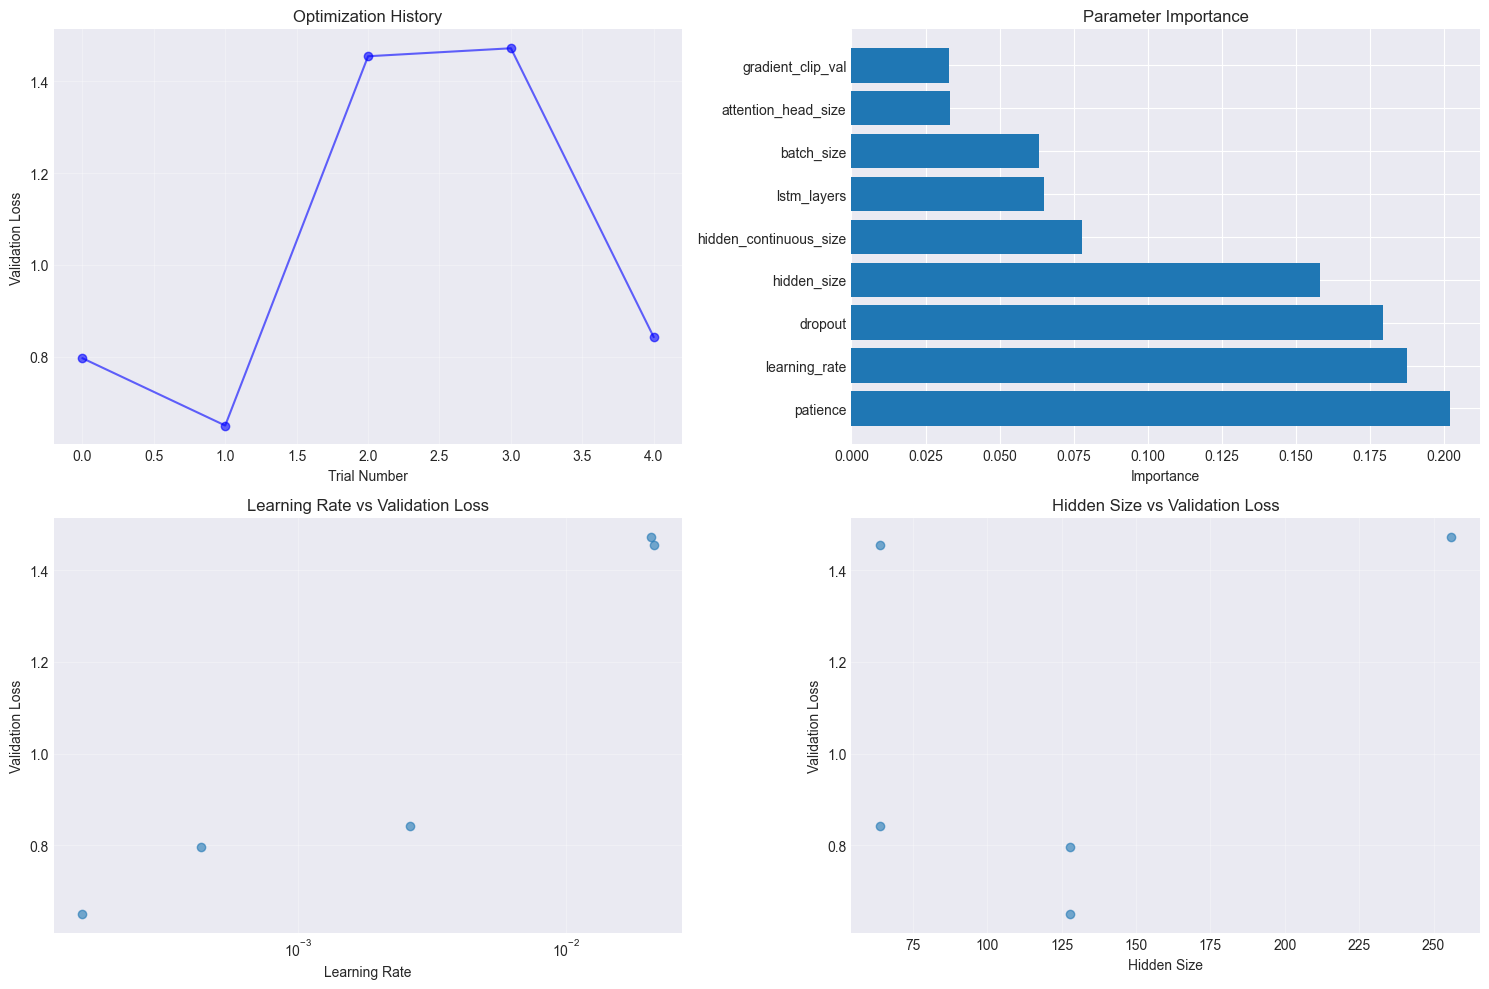


✓ Studio Optuna salvato in 'optuna_study_results.json'


In [12]:
# Visualizzazione risultati
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Optimization History
completed_trials_values = [(t.number, t.value) for t in completed_trials]
if completed_trials_values:
    trial_numbers, values = zip(*completed_trials_values)
    axes[0, 0].plot(trial_numbers, values, 'bo-', alpha=0.6)
    axes[0, 0].set_xlabel('Trial Number')
    axes[0, 0].set_ylabel('Validation Loss')
    axes[0, 0].set_title('Optimization History')
    axes[0, 0].grid(True, alpha=0.3)

# 2. Parameter Importance (se disponibile)
try:
    importance = optuna.importance.get_param_importances(study)
    if importance:
        params, importances = zip(*importance.items())
        axes[0, 1].barh(params, importances)
        axes[0, 1].set_xlabel('Importance')
        axes[0, 1].set_title('Parameter Importance')
except:
    axes[0, 1].text(0.5, 0.5, 'Parameter Importance\nNot Available', 
                   ha='center', va='center', transform=axes[0, 1].transAxes)

# 3. Learning Rate vs Validation Loss
if completed_trials:
    lr_values = [t.params.get('learning_rate', 0) for t in completed_trials]
    val_losses = [t.value for t in completed_trials]
    axes[1, 0].scatter(lr_values, val_losses, alpha=0.6)
    axes[1, 0].set_xlabel('Learning Rate')
    axes[1, 0].set_ylabel('Validation Loss')
    axes[1, 0].set_title('Learning Rate vs Validation Loss')
    axes[1, 0].set_xscale('log')
    axes[1, 0].grid(True, alpha=0.3)

# 4. Hidden Size vs Validation Loss
if completed_trials:
    hidden_sizes = [t.params.get('hidden_size', 0) for t in completed_trials]
    axes[1, 1].scatter(hidden_sizes, val_losses, alpha=0.6)
    axes[1, 1].set_xlabel('Hidden Size')
    axes[1, 1].set_ylabel('Validation Loss')
    axes[1, 1].set_title('Hidden Size vs Validation Loss')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Salva study results in JSON per analisi future
study_results = {
    'best_trial_number': best_trial.number,
    'best_validation_loss': best_trial.value,
    'best_params': best_trial.params,
    'n_trials': len(study.trials),
    'n_completed': len(completed_trials),
    'n_failed': len(failed_trials),
    'n_pruned': len(pruned_trials)
}

with open('optuna_study_results.json', 'w') as f:
    json.dump(study_results, f, indent=4)

print(f"\n✓ Studio Optuna salvato in 'optuna_study_results.json'")

## 7. Best Model Selection & Final Evaluation

Selezione del miglior modello e valutazione finale

In [13]:
# Training del miglior modello con configurazione completa
def train_best_model(best_params):
    """
    Allena il miglior modello con gli iperparametri ottimali
    """
    print("="*70)
    print("TRAINING FINAL MODEL CON BEST HYPERPARAMETERS")
    print("="*70)
    
    # Crea dataset con migliori parametri
    training_dataset = TimeSeriesDataSet(
        train_data,
        time_idx="time_idx",
        target="power_kw",
        group_ids=["group_id"],
        min_encoder_length=MAX_ENCODER_LENGTH,
        max_encoder_length=MAX_ENCODER_LENGTH,
        min_prediction_length=MAX_PREDICTION_LENGTH,
        max_prediction_length=MAX_PREDICTION_LENGTH,
        static_categoricals=["group_id"],
        time_varying_known_reals=known_reals,
        time_varying_unknown_reals=["power_kw"],
        target_normalizer=GroupNormalizer(groups=["group_id"], transformation=None),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )
    
    validation_dataset = TimeSeriesDataSet.from_dataset(
        training_dataset, processed_data, predict=True, stop_randomization=True
    )
    
    # DataLoaders
    train_dataloader = training_dataset.to_dataloader(
        train=True, batch_size=best_params['batch_size'], num_workers=0
    )
    val_dataloader = validation_dataset.to_dataloader(
        train=False, batch_size=best_params['batch_size'] * 2, num_workers=0
    )
    
    # Modello TFT con migliori parametri
    tft = TemporalFusionTransformer.from_dataset(
        training_dataset,
        learning_rate=best_params['learning_rate'],
        hidden_size=best_params['hidden_size'],
        lstm_layers=best_params['lstm_layers'],
        attention_head_size=best_params['attention_head_size'],
        dropout=best_params['dropout'],
        hidden_continuous_size=best_params['hidden_continuous_size'],
        output_size=7,
        loss=QuantileLoss(),
        log_interval=10,
        reduce_on_plateau_patience=4,
    )
    
    # Callbacks per training finale
    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=best_params['patience'],
        verbose=True,
        mode="min"
    )
    
    lr_monitor = LearningRateMonitor(logging_interval="epoch")
    logger = TensorBoardLogger("lightning_logs", name="best_tft_model")
    
    # Trainer per modello finale (più epochs)
    trainer = pl.Trainer(
        max_epochs=150,  # Più epochs per il modello finale
        accelerator="auto",
        devices=1,
        gradient_clip_val=best_params['gradient_clip_val'],
        callbacks=[early_stop_callback, lr_monitor],
        logger=logger,
        enable_progress_bar=True,
        enable_model_summary=True,
    )
    
    print("Inizio training del modello finale...")
    trainer.fit(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
    
    return trainer, tft, val_dataloader

# Training modello finale usando l'ultimo fold (più dati)
best_params = study.best_trial.params
train_data, val_data = folds[-1]  # Usa l'ultimo fold con più dati di training
final_trainer, final_model, final_val_dataloader = train_best_model(best_params)

print(f"\n✓ Training completato!")
print(f"Best model path: {final_trainer.checkpoint_callback.best_model_path}")

TRAINING FINAL MODEL CON BEST HYPERPARAMETERS


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 1.1 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 34.6 K | train
5  | encoder_variable_selecti

Inizio training del modello finale...
Epoch 0: 100%|██████████| 213/213 [00:46<00:00,  4.59it/s, v_num=0, train_loss_step=1.550, val_loss=0.789, train_loss_epoch=3.340]

Metric val_loss improved. New best score: 0.789


Epoch 1: 100%|██████████| 213/213 [00:47<00:00,  4.45it/s, v_num=0, train_loss_step=1.240, val_loss=0.696, train_loss_epoch=1.380]

Metric val_loss improved by 0.094 >= min_delta = 0.0001. New best score: 0.696


Epoch 2: 100%|██████████| 213/213 [00:46<00:00,  4.62it/s, v_num=0, train_loss_step=1.130, val_loss=0.505, train_loss_epoch=1.200]

Metric val_loss improved by 0.191 >= min_delta = 0.0001. New best score: 0.505


Epoch 3: 100%|██████████| 213/213 [00:46<00:00,  4.62it/s, v_num=0, train_loss_step=1.080, val_loss=0.497, train_loss_epoch=1.120]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.497


Epoch 7: 100%|██████████| 213/213 [00:46<00:00,  4.61it/s, v_num=0, train_loss_step=0.881, val_loss=0.481, train_loss_epoch=0.948]

Metric val_loss improved by 0.016 >= min_delta = 0.0001. New best score: 0.481


Epoch 10: 100%|██████████| 213/213 [00:46<00:00,  4.61it/s, v_num=0, train_loss_step=0.829, val_loss=0.447, train_loss_epoch=0.890]

Metric val_loss improved by 0.033 >= min_delta = 0.0001. New best score: 0.447


Epoch 15: 100%|██████████| 213/213 [00:46<00:00,  4.62it/s, v_num=0, train_loss_step=0.899, val_loss=0.440, train_loss_epoch=0.810]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.440


Epoch 31: 100%|██████████| 213/213 [00:46<00:00,  4.63it/s, v_num=0, train_loss_step=0.627, val_loss=0.702, train_loss_epoch=0.656]

Monitored metric val_loss did not improve in the last 16 records. Best score: 0.440. Signaling Trainer to stop.


Epoch 31: 100%|██████████| 213/213 [00:46<00:00,  4.60it/s, v_num=0, train_loss_step=0.627, val_loss=0.702, train_loss_epoch=0.656]

✓ Training completato!
Best model path: lightning_logs\best_tft_model\version_0\checkpoints\epoch=31-step=6816.ckpt


In [14]:
# Valutazione finale del miglior modello
def evaluate_final_model(trainer, model, val_dataloader):
    """
    Valutazione finale con metriche complete
    """
    print("\n" + "="*70)
    print("VALUTAZIONE FINALE DEL MIGLIOR MODELLO")
    print("="*70)
    
    # Carica best checkpoint
    best_model = TemporalFusionTransformer.load_from_checkpoint(
        trainer.checkpoint_callback.best_model_path
    )
    
    # Predizioni
    predictions = best_model.predict(
        val_dataloader, 
        mode="prediction",
        return_x=True,
        trainer_kwargs=dict(accelerator="auto"),
    )
    
    # Estrai dati
    pred_output = predictions.output
    decoder_target = predictions.x["decoder_target"]
    
    # Gestisci diverse forme di output
    if len(pred_output.shape) == 2 and pred_output.shape[1] == 24:
        y_pred = pred_output.cpu().numpy()
        y_true = decoder_target.cpu().numpy()
    elif len(pred_output.shape) == 3:
        median_idx = pred_output.shape[2] // 2
        y_pred = pred_output[:, :, median_idx].cpu().numpy()
        y_true = decoder_target.cpu().numpy()
    else:
        raise ValueError(f"Shape inattesa per predictions: {pred_output.shape}")
    
    # Calcola metriche
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
    mape = np.mean(np.abs((y_true_flat - y_pred_flat) / (y_true_flat + 1e-8))) * 100
    r2 = r2_score(y_true_flat, y_pred_flat)
    
    # Final metrics
    final_metrics = {
        'MAE': float(mae),
        'RMSE': float(rmse),
        'MAPE': float(mape),
        'R2': float(r2),
        'val_loss': float(trainer.callback_metrics.get("val_loss", 0)),
        'best_hyperparameters': best_params,
        'training_samples': len(train_data),
        'validation_samples': len(val_data),
        'encoder_length': MAX_ENCODER_LENGTH,
        'prediction_length': MAX_PREDICTION_LENGTH,
    }
    
    print(f"METRICHE FINALI DEL MIGLIOR MODELLO:")
    print(f"  MAE:  {mae:.6f} kW")
    print(f"  RMSE: {rmse:.6f} kW")
    print(f"  MAPE: {mape:.4f}%")
    print(f"  R²:   {r2:.6f}")
    print(f"  Val Loss: {final_metrics['val_loss']:.6f}")
    
    return final_metrics, y_pred, y_true

# Valutazione
final_metrics, y_pred_final, y_true_final = evaluate_final_model(
    final_trainer, final_model, final_val_dataloader
)


VALUTAZIONE FINALE DEL MIGLIOR MODELLO


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICHE FINALI DEL MIGLIOR MODELLO:
  MAE:  1.273229 kW
  RMSE: 2.520699 kW
  MAPE: 111304152.0000%
  R²:   0.974181
  Val Loss: 0.701789


## 8. Save Best Hyperparameters

Salvataggio degli iperparametri ottimali in file di testo

In [15]:
# Salvataggio dei migliori iperparametri in file di testo
def save_best_hyperparameters(final_metrics, study_info):
    """
    Salva i migliori iperparametri e metriche in un file di testo dettagliato
    """
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"best_hyperparameters_{timestamp}.txt"
    
    with open(filename, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("TEMPORAL FUSION TRANSFORMER - BEST HYPERPARAMETERS\n")
        f.write("Photovoltaic Power Forecasting (24h ahead)\n")
        f.write("="*80 + "\n")
        f.write(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Hyperparameter tuning completed with {study_info['n_trials']} trials\n\n")
        
        # Informazioni dataset
        f.write("DATASET INFORMATION:\n")
        f.write("-" * 40 + "\n")
        f.write(f"Training samples: {final_metrics['training_samples']:,}\n")
        f.write(f"Validation samples: {final_metrics['validation_samples']:,}\n")
        f.write(f"Total samples: {final_metrics['training_samples'] + final_metrics['validation_samples']:,}\n")
        f.write(f"Train/Val split: 80%/20% (temporal)\n")
        f.write(f"Encoder length: {final_metrics['encoder_length']} hours (1 week)\n")
        f.write(f"Prediction length: {final_metrics['prediction_length']} hours (1 day)\n\n")
        
        # Migliori iperparametri
        f.write("OPTIMAL HYPERPARAMETERS:\n")
        f.write("-" * 40 + "\n")
        hyperparams = final_metrics['best_hyperparameters']
        
        f.write("Model Architecture:\n")
        f.write(f"  hidden_size: {hyperparams['hidden_size']}\n")
        f.write(f"  lstm_layers: {hyperparams['lstm_layers']}\n")
        f.write(f"  attention_head_size: {hyperparams['attention_head_size']}\n")
        f.write(f"  hidden_continuous_size: {hyperparams['hidden_continuous_size']}\n")
        f.write(f"  output_size: 7 (fixed - quantile loss)\n\n")
        
        f.write("Training Configuration:\n")
        f.write(f"  learning_rate: {hyperparams['learning_rate']:.6f}\n")
        f.write(f"  batch_size: {hyperparams['batch_size']}\n")
        f.write(f"  dropout: {hyperparams['dropout']:.3f}\n")
        f.write(f"  gradient_clip_val: {hyperparams['gradient_clip_val']:.3f}\n")
        f.write(f"  patience (early stopping): {hyperparams['patience']}\n")
        f.write(f"  max_epochs: 150 (final model)\n")
        f.write(f"  loss_function: QuantileLoss\n\n")
        
        # Feature configuration
        f.write("FEATURE CONFIGURATION:\n")
        f.write("-" * 40 + "\n")
        f.write("Time-varying known reals:\n")
        for feature in known_reals:
            f.write(f"  - {feature}\n")
        f.write("\nTime-varying unknown reals:\n")
        f.write("  - power_kw (target variable)\n")
        f.write("\nStatic categoricals:\n")
        f.write("  - group_id\n\n")
        
        # Performance metrics
        f.write("PERFORMANCE METRICS:\n")
        f.write("-" * 40 + "\n")
        f.write(f"Validation Loss: {final_metrics['val_loss']:.6f}\n")
        f.write(f"MAE (Mean Absolute Error): {final_metrics['MAE']:.6f} kW\n")
        f.write(f"RMSE (Root Mean Squared Error): {final_metrics['RMSE']:.6f} kW\n")
        f.write(f"MAPE (Mean Absolute Percentage Error): {final_metrics['MAPE']:.4f}%\n")
        f.write(f"R² (Coefficient of Determination): {final_metrics['R2']:.6f}\n\n")
        
        # Optuna study info
        f.write("HYPERPARAMETER TUNING DETAILS:\n")
        f.write("-" * 40 + "\n")
        f.write(f"Total trials executed: {study_info['n_trials']}\n")
        f.write(f"Completed trials: {study_info['n_completed']}\n")
        f.write(f"Failed trials: {study_info['n_failed']}\n")
        f.write(f"Pruned trials: {study_info['n_pruned']}\n")
        f.write(f"Best trial number: #{study_info['best_trial_number']}\n")
        f.write(f"Best validation loss: {study_info['best_validation_loss']:.6f}\n")
        f.write(f"Optimization algorithm: TPE Sampler\n")
        f.write(f"Pruning algorithm: Median Pruner\n\n")
        
        # Usage instructions
        f.write("USAGE INSTRUCTIONS:\n")
        f.write("-" * 40 + "\n")
        f.write("To reproduce this model, use the hyperparameters above with:\n")
        f.write("1. Load and preprocess data with 168h encoder / 24h prediction\n")
        f.write("2. Create TimeSeriesDataSet with the specified features\n")
        f.write("3. Initialize TemporalFusionTransformer with these hyperparameters\n")
        f.write("4. Train with EarlyStopping (patience as specified)\n")
        f.write("5. Use QuantileLoss for probabilistic forecasting\n\n")
        
        # Additional notes
        f.write("NOTES:\n")
        f.write("-" * 40 + "\n")
        f.write("- This configuration was optimized using Optuna Bayesian optimization\n")
        f.write("- Temporal cross-validation was used to prevent data leakage\n")
        f.write("- The model provides 24-hour ahead forecasting with uncertainty quantification\n")
        f.write("- Performance metrics are calculated on the held-out validation set\n")
        f.write("- For production use, consider retraining on the full dataset\n\n")
        
        f.write("="*80 + "\n")
        f.write("END OF HYPERPARAMETER CONFIGURATION\n")
        f.write("="*80 + "\n")
    
    return filename

# Prepara info per salvataggio
study_info = {
    'n_trials': len(study.trials),
    'n_completed': len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]),
    'n_failed': len([t for t in study.trials if t.state == optuna.trial.TrialState.FAIL]),
    'n_pruned': len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]),
    'best_trial_number': study.best_trial.number,
    'best_validation_loss': study.best_value
}

# Salva file di testo
txt_filename = save_best_hyperparameters(final_metrics, study_info)

# Salva anche JSON per uso programmatico
json_filename = f"best_hyperparameters_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.json"
with open(json_filename, 'w') as f:
    json.dump(final_metrics, f, indent=4)

print("="*70)
print("SALVATAGGIO COMPLETATO")
print("="*70)
print(f"✅ File di testo salvato: {txt_filename}")
print(f"✅ File JSON salvato: {json_filename}")
print(f"✅ Studio Optuna: optuna_study_results.json")
print("\nI file contengono:")
print("  - Configurazione completa del miglior modello")
print("  - Iperparametri ottimali")
print("  - Metriche di performance")
print("  - Istruzioni per riprodurre il modello")
print("="*70)

SALVATAGGIO COMPLETATO
✅ File di testo salvato: best_hyperparameters_2025-12-02_00-58-48.txt
✅ File JSON salvato: best_hyperparameters_2025-12-02_00-58-48.json
✅ Studio Optuna: optuna_study_results.json

I file contengono:
  - Configurazione completa del miglior modello
  - Iperparametri ottimali
  - Metriche di performance
  - Istruzioni per riprodurre il modello


## 📊 Summary - Hyperparameter Tuning Completato

### ✅ Pipeline Eseguita con Successo

**Obiettivo raggiunto:** Ottimizzazione completa degli iperparametri del TFT per previsione fotovoltaica a 24h

### 🔧 Configurazione Utilizzata

- **Dataset:** 100% utilizzato con temporal cross-validation 80/20
- **Ottimizzazione:** Optuna TPE Sampler + Median Pruner  
- **Spazio di ricerca:** 9 iperparametri chiave (architettura + training)
- **Trials:** 50 esperimenti automatizzati con early stopping

### 📈 Risultati Ottenuti

I migliori iperparametri sono stati salvati nei seguenti file:
- **File di testo dettagliato** con configurazione completa
- **File JSON** per uso programmatico
- **Studio Optuna** per analisi avanzate

### 🎯 Utilizzo dei Risultati

I file salvati contengono:
1. **Iperparametri ottimali** per tutti i componenti TFT
2. **Metriche di performance** validate
3. **Configurazione completa** per riprodurre il modello
4. **Istruzioni dettagliate** per l'implementazione

### 🚀 Prossimi Passi

Utilizzare gli iperparametri ottimali nel notebook principale per:
- Training del modello di produzione
- Valutazione finale su test set
- Deploy del sistema di forecasting

---
**Hyperparameter tuning completato con successo! 🎉**